In [1]:
import pandas as pd
import numpy as np

from scipy.io import wavfile
from scipy.fftpack import fft, fftfreq, rfft, rfftfreq, irfft
import scipy.signal as signal
from matplotlib.widgets import Slider, Button, RadioButtons


from bokeh.layouts import row, widgetbox
from bokeh.models import CustomJS, Slider
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.io import output_notebook
output_notebook()

import matplotlib.pyplot as plt
%matplotlib inline

train_df = pd.read_csv('train.csv')
def show_me(filename):
    rate, data = wavfile.read('audio_train/' + filename)
    plt.plot(data, '-')
    plt.show()
    print("framerate (sample rate): {}".format(rate))
    return rate, data

Loading BokehJS ...

### Functions

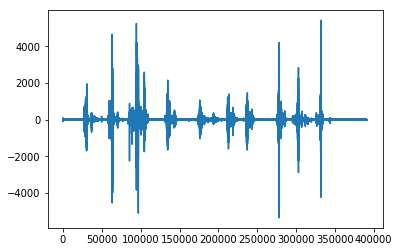

framerate (sample rate): 44100


In [4]:
man_df = train_df[train_df['manually_verified'] == 1]
verified_df = man_df.groupby(by=['label', 'manually_verified']).count().sum(axis=1)
verified_df = verified_df.unstack().reindex(verified_df.unstack().sum(axis=1).sort_values().index)
# get all labels' manually verified filenames
verified_df.unstack()

scissors_verified_list = man_df['fname'][man_df['label'] == 'Scissors']
scissors_verified_list = scissors_verified_list.tolist()

rate, signal = show_me(scissors_verified_list[0])

### Feature Engineering

#### Low Pass Filter (Removes higher frequencies from data signal)

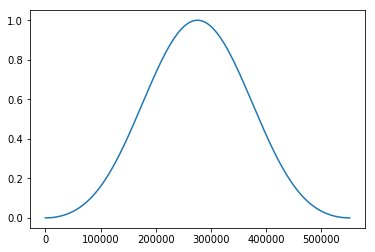

In [7]:
# frequency cutoff
def resample_wrt_b(b=0.08):
    # N = re-sampled according to new bandpass rate
    N = int(np.ceil((rate/b)))
    if not N % 2 : N = N + 1
    return N

def low_pass(fc, N, n):
    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)
    return sinc_func, window

def high_pass(fc, N, n):
    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = np.blackman(N)
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)
    # reverse function
    sinc_func = -sinc_func
    sinc_func[int((N - 1) / 2)] += 1
    return window, sinc_func

fc = 0.5
N = resample_wrt_b(b = 0.08)
n = np.arange(N)

# low_pass_sinc, low_window = low_pass(fc, N, n)
# plt.plot(n, low_window, n, low_pass_sinc)

high_pass_sinc, high_window = high_pass(fc, N, n)

# source = ColumnDataSource(data=dict(x = window, y = high_pass_sinc))
# plot = figure(y_range=(min(), 10), plot_width=400, plot_height=400)

# plt.plot(n, high_window, n, high_pass_sinc)
plt.plot(n, high_pass_sinc)
plt.show()